In [6]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import dummy, preprocessing, linear_model, svm, model_selection, ensemble
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import xgboost as xgb
import json


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

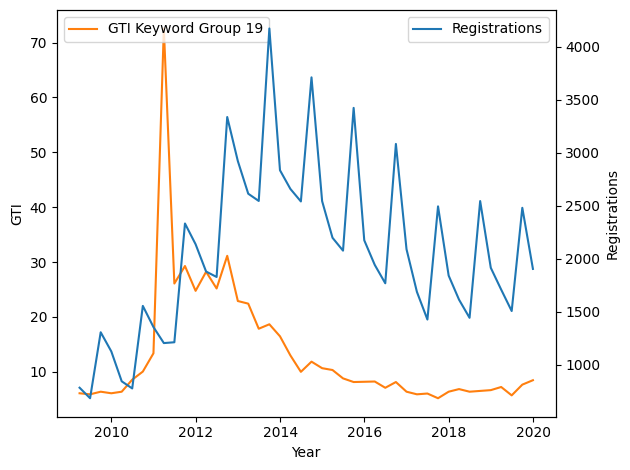

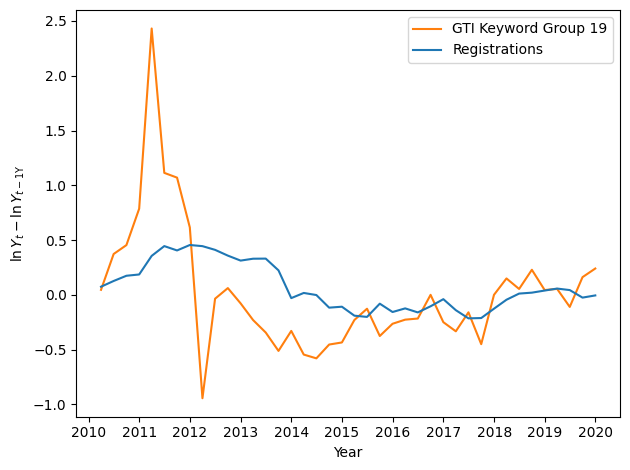

In [3]:
labeled = eumf_pipeline.prepare_data(
    panel_comb_3m_macro,
    columns=["19"],
    lags=[0],
)
transformed = eumf_pipeline.transform_data(labeled)

# sns.lineplot(data=labeled.x["19_0", "ES"], label="GTI Keyword Group 19")
# ax2 = plt.twinx()
# sns.lineplot(data=labeled.y["ES"], label="Registrations", ax=ax2)
# plt.show()

# ax = labeled.x["19_0", "ES"].plot(legend=True, label="GTI Keyword Group 19", color="tab:orange")
ax = sns.lineplot(data=labeled.x["19_0", "ES"], label="GTI Keyword Group 19", color="tab:orange")
ax2 = ax.twinx()
# labeled.y["ES"].plot(ax=ax2, legend=True, color="tab:blue", label = "Registrations")
sns.lineplot(data=labeled.y["ES"], ax=ax2, label="Registrations", color="tab:blue")
# ax.figure.legend()
ax.set_ylabel("GTI")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax2.set_ylabel("Registrations")
ax.set_xlabel("Year")
plt.tight_layout()
plt.savefig("plots/gti_registrations_spain.pdf")
plt.show()

# ax = transformed.x["19_0", "ES"].plot(legend=True, label="GTI Keyword Group 19", color="tab:orange")
ax = sns.lineplot(data=transformed.x["19_0", "ES"], label="GTI Keyword Group 19", color="tab:orange")
# ax2 = ax.twinx()
# transformed.y["ES"].plot(legend=True, color="tab:blue", label = "Registrations")
sns.lineplot(data=transformed.y["ES"], ax=ax, label="Registrations", color="tab:blue")
#  ax.figure.legend(loc="upper right")
plt.xlabel("Year")
ax.set_ylabel("$\ln Y_t - \ln Y_{t-1\operatorname{Y}}$")
# ax2.set_ylabel("Registrations")
plt.tight_layout()
plt.savefig("plots/gti_registrations_spain_transformed.pdf")
plt.show()

## Global definitions

In [7]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

cv_scores_global, test_scores_global = [], []

with open("best_feature_combinations.json") as f:
    best_feature_combinations = json.load(f)

selected_keyword_ids = [
    "19",
    "118",
    "28",
    "24",
    "123",
    "119",
    "39",
    "115",
    "124",
    "117",
]

lags_default = [1, 2, 3, 4, 5, 6, 7, 8]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6, 7, 8],
    "gdp": [2, 3, 4, 5, 6, 7, 8],
    "unempl": [2, 3, 4, 5, 6, 7, 8],
}

variables_default = ["value", "gdp", "unempl"] + selected_keyword_ids

## Create comparison models

### Linear model

In [8]:
### TRAINING


model_names = [
    "bench_const_0",
    "bench_previous_2",
    "linear_without_ar",
    "linear_all",
    "linear_without_google",
    "ensemble_without_ar",
    "ensemble_all",
    "ensemble_without_google",
]

features = [
    ["value_2"],
    ["value_2"],
    best_feature_combinations["linear"]["without_ar"],
    best_feature_combinations["linear"]["all"],
    best_feature_combinations["linear"]["without_google"],
    best_feature_combinations["ensemble"]["without_ar"],
    best_feature_combinations["ensemble"]["all"],
    best_feature_combinations["ensemble"]["without_google"],
]

estimators = [
    dummy.DummyRegressor(strategy="constant", constant=0),
    eumf_custom_models.LinearDummyModel(coef=[1.0]),
    linear_model.HuberRegressor(epsilon=1.1, alpha=0.08),
    linear_model.HuberRegressor(epsilon=1.7, alpha=0.00008),
    linear_model.HuberRegressor(epsilon=1.0, alpha=0.002),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=9),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=11),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=12),
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for i, name in enumerate(tqdm(model_names)):
    print(name)
    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=variables_default,
        lags=lags_default,
        alternate_lags=alternate_lags_default,
        t_min=T_MIN,
        t_max=T_MAX,
    )
    labeled.x = labeled.x[features[i]]
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(
        train, test, extra_column=False if model_names[i].startswith("bench_") else True
    )

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if model_names[i].startswith("bench_"):
        tuner = None
        estimator = estimators[i].fit(train_stacked.x, train_stacked.y)
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=estimators[i],
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_mae,
            cv=cv_default,
            # cv=cv_default,
            dummy_encoder="drop",
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators[i] = estimator

    cv_score = eumf_eval.score_cv(
        estimator, train_stacked, cv=cv_default, return_train_score=True
    )
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(
        estimator,
        test_stacked,
    )
    test_scores.append(test_score)


  0%|          | 0/8 [00:00<?, ?it/s]

bench_const_0


 12%|█▎        | 1/8 [00:01<00:08,  1.16s/it]

bench_previous_2


/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDummyModel was fitted without feature names
  warnings.warn(
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDummyModel was fitted without feature names
  warnings.warn(
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDummyModel was fitted without feature names
  warnings.warn(
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDummyModel was fitted without feature names
  warnings.warn(
/home/stei509/eu_migration_forecast/.venv/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearDummyModel was fitted without feature names
  warnings.warn(
/home/stei509/e

linear_without_ar


 38%|███▊      | 3/8 [00:04<00:07,  1.53s/it]

linear_all


 50%|█████     | 4/8 [00:07<00:08,  2.02s/it]

linear_without_google


 62%|██████▎   | 5/8 [00:08<00:05,  1.95s/it]

ensemble_without_ar


 75%|███████▌  | 6/8 [00:22<00:11,  5.83s/it]

ensemble_all


 88%|████████▊ | 7/8 [00:34<00:08,  8.02s/it]

ensemble_without_google


100%|██████████| 8/8 [00:40<00:00,  5.03s/it]


In [10]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                       score_time                       test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                          mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
bench_const_0             0.003   1.215e-03  4.296e-04    0.005    1.272e-03  4.496e-04  -0.127   0.071  0.025   -0.129   0.018  0.006   -0.180   0.094  0.033   -0.202    0.024  0.009           0.000          0.000  0.000           0.000           0.000  0.000     0.000    0.000  0.000     0.000     0.000  0.000      0.000      0.000  0.000       0.000      0.000  0.000
bench_previous_2          0.002   3.097e-04  1.095e-04    0.007    6.648e-04  2.351e-04  -0.092   0.020  0.007   -0.093   0.005  0.002   -0.139   0.047  0.017   -0.146    0.012  0.004           0.107          0.201  0.071           0.388           0.077  0.027     0.231    0.305  0.108     0.466     0.097  0.034      0.034      0.056  0.020       0.037      0.014  0.005
linear_without_ar         0.031   6.804e-03  2.406e-03    0.013    3.157e-03  1.116e-03  -0.088   0.029  0.010   -0.082   0.006  0.002   -0.131   0.050  0.018   -0.135    0.010  0.004           0.184          0.292  0.103           0.486           0.034  0.012     0.338    0.329  0.116     0.547     0.059  0.021      0.038      0.044  0.016       0.047      0.012  0.004
linear_all                0.152   1.809e-01  6.397e-02    0.015    4.400e-03  1.556e-03  -0.071   0.019  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.425          0.191  0.068           0.673           0.036  0.013     0.539    0.213  0.075     0.715     0.047  0.017      0.056      0.054  0.019       0.063      0.015  0.005
linear_without_google     0.049   1.247e-02  4.409e-03    0.007    1.885e-03  6.664e-04  -0.077   0.024  0.009   -0.075   0.005  0.002   -0.115   0.045  0.016   -0.119    0.010  0.004           0.375          0.221  0.078           0.596           0.044  0.016     0.466    0.245  0.087     0.646     0.055  0.020      0.049      0.050  0.018       0.055      0.014  0.005
ensemble_without_ar       1.041   1.903e-01  6.729e-02    0.016    1.734e-03  6.129e-04  -0.093   0.030  0.011   -0.058   0.004  0.001   -0.134   0.046  0.016   -0.095    0.008  0.003           0.126          0.377  0.133           0.736           0.051  0.018     0.230    0.469  0.166     0.770     0.060  0.021      0.034      0.050  0.018       0.071      0.015  0.005
ensemble_all              0.966   9.125e-02  3.226e-02    0.016    4.362e-03  1.542e-03  -0.082   0.025  0.009   -0.057   0.003  0.001   -0.122   0.047  0.017   -0.097    0.009  0.003           0.328          0.120  0.043           0.724           0.058  0.021     0.442    0.205  0.072     0.759     0.067  0.024      0.045      0.051  0.018       0.072      0.016  0.006
ensemble_without_google   0.347   7.911e-02  2.797e-02    0.016    2.835e-03  1.002e-03  -0.089   0.028  0.010   -0.068   0.004  0.001   -0.129   0.049  0.017   -0.109    0.009  0.003           0.259          0.111  0.039           0.652           0.063  0.022     0.381    0.208  0.074     0.697     0.075  0.026      0.038      0.046  0.016       0.061      0.014  0.005

/tmp/ipykernel_14544/741857112.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


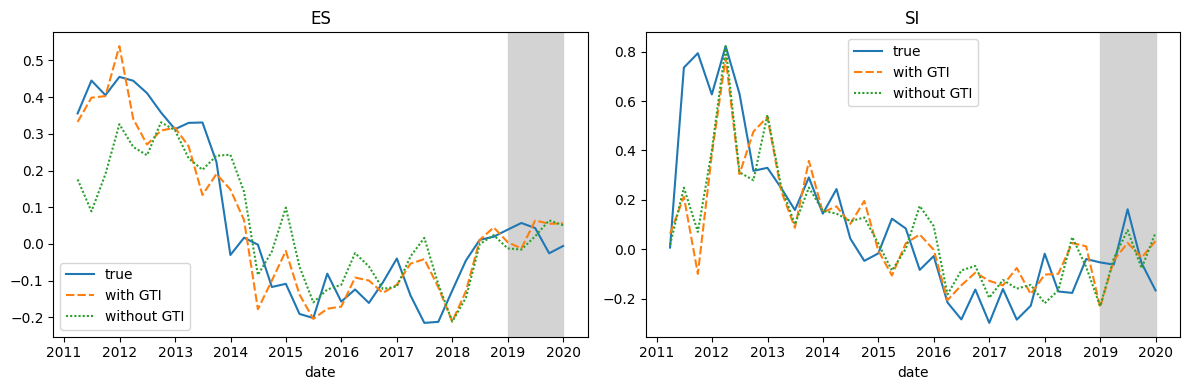

In [11]:
i1 = model_names.index("linear_all")
i2 = model_names.index("linear_without_google")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"with GTI": y_pred_i1, "without GTI": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    countries=["ES", "SI"],
    n_rows=1,
    n_cols=2,
    figsize=(12, 4),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.tight_layout()
plt.savefig("plots/prediction_examples.pdf")
plt.show()